# Business Bankruptcy Prediction

## Contents

1. Introduction
1. Preparation
1. Exploration
1. Data preprocessing
1. Data modelling
 1. Model fitting
 1. Model evaluation
1. Results
1. Conclusion

## Introduction

Each. row represents a company and each column (apart from the last one) are characteristics of each company at the time of assessment. The last column, our target, denotes whether a company filed for. bankruptcy (1) or not (0). within a year from the assessment.

The main objective of this exercise is to deliver a model that predicts whether a company will file for bankruptcy in the next year.

Apart from delivering the model itself, it is expected. that the candidate will carry out some initial data exploration in order to get a better understanding of the data prior to traiining the model and also an in-depth analysis on the performance of the model aftewards.

## Preparation

Before we get started we need to make sure we're ready to go. We start by importing our necessary packages and loading our dataset. 

In [15]:
## core packages
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

## statistical packages
from collections import Counter

## graphical packages
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

## preprocessing packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTENC

## model packages
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from sklearn.model_selection import RandomizedSearchCV, KFold, cross_validate
# lgbm

## model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve

In [16]:
dataset = pd.read_csv("business_bankruptcy_prediction.csv")

We've now loaded in our dataset, lets take a look to see what it looks like:

In [17]:
dataset.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Company type,Bankruptcy
0,0.370594,0.424389,0.405750,0.601457,0.6014572133,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,Partnership,1
1,0.464291,0.538214,0.516730,0.610235,0.6102350855,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,Partnership,1
2,0.426071,0.499019,0.472295,0.601450,0.601363525,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,Partnership,1
3,0.399844,0.451265,0.457733,0.583541,0.5835411292,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,Partnership,1
4,0.465022,0.538432,0.522298,0.598783,0.5987834936,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,Limited Company,1


## Exploration

Our dataset is now imported, so we can start exploring it. 

The variable we're going to be predicting is the final column: bankruptcy. As we have a binary classification, i.e. did go bankrupt vs did not go bankrupt, it doesn't make sense to describe the make-up of the column, what we should explore is the balance of the variable:

In [18]:
## we find the counts of the classes using the Counter
balance = Counter(dataset['Bankruptcy'])

## we now find the % of the dataset which goes bankrupt 
bankruptcyAmount = balance[1]/(balance[1]+balance[0])

print("{:.2%} of the dataset goes bankrupt".format(bankruptcyAmount))

3.23% of the dataset goes bankrupt


Our dataset has a balance problem - of the 6819 samples we have, only 3.23% of companies go bankrupt. That means that if we were to predict no company would go bankrupt, our initial accuracy would be 96.77%.

We can now inspect the rest of our data. When we initially had a look at the layout of the data I noticed there were some categoric columns, so we check our column make-up:

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 97 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1    ROA(A) before interest and % after tax                   6819 non-null   float64
 2    ROA(B) before interest and depreciation after tax        6818 non-null   float64
 3    Operating Gross Margin                                   6819 non-null   float64
 4    Realized Sales Gross Margin                              6818 non-null   object 
 5    Operating Profit Rate                                    6819 non-null   float64
 6    Pre-tax net Interest Rate                                6819 non-null   float64
 7    After-tax net Interest Rate                              6819 non-null   float64
 8    Non-industry inco

Looking at the above we can see some issues: we have some data types as objects where we shouldn't, and that some of our columns contain nulls. 

Let's see which of our columns contain null values:

In [20]:
## we iterate over the columns and find those with null values, we can see from above that they're very sparse
nullCols = [col for col in dataset if dataset[col].isna().sum() > 0]

nullCols 

[' ROA(B) before interest and depreciation after tax',
 ' Realized Sales Gross Margin',
 ' Net Value Per Share (C)',
 ' Per Share Net profit before tax (Yuan ¬•)',
 ' Regular Net Profit Growth Rate',
 ' Net Value Growth Rate',
 ' Inventory and accounts receivable/Net value',
 ' Inventory/Working Capital']

In [21]:
dataset.isna().sum()

 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          1
 Operating Gross Margin                                     0
 Realized Sales Gross Margin                                1
 Operating Profit Rate                                      0
 Pre-tax net Interest Rate                                  0
 After-tax net Interest Rate                                0
 Non-industry income and expenditure/revenue                0
 Continuous interest rate (after tax)                       0
 Operating Expense Rate                                     0
 Research and development expense rate                      0
 Cash flow rate                                             0
 Interest-bearing debt interest rate                        0
 Tax rate (A)                                               0
 Net Value Per Share (B)                                    0
 Net Val

These are the 8 columns that contain null values, depending on the structure of the rest of our data (for instance, how many outliers we have, etc), we will choose whether or not to impute values into the nulls or remove the columns altogether.

We now want to look at our object data and ensure they're correctly lapsed as categories or numbers:

In [22]:
objectCols = [col for col in dataset if dataset[col].dtypes == 'object'] 

objectCols

[' Realized Sales Gross Margin', ' Allocation rate per person', 'Company type']

These are our object columns, we can see beloiw that Realized Sales Gross Margin and Allocation rate per person are in fact floats and are misclassified, and Company type is a category.

In [23]:
dataset[objectCols].head()

,Realized Sales Gross Margin,Allocation rate per person,Company type
0,0.6014572133,0.03713530158,Partnership
1,0.6102350855,0.01233497213,Partnership
2,0.601363525,0.1410163119,Partnership
3,0.5835411292,0.02131998974,Partnership
4,0.5987834936,0.02398821165,Limited Company


We check the first two columns for strings that may be causing the issue using regex, and set these values equal to NaN - we're going to be imputing values there anyway so we're safe to do that right now.

In [24]:
for col in dataset[objectCols[0:2]]:
    stringValue = dataset[col].str.match('^[+-]?\d*\.?\d+$', na=True)
    dataset[col] = dataset[col].mask(stringValue == False, np.NaN)

We can now fix the above by changing their classes:

In [25]:
dataset = dataset.astype({' Realized Sales Gross Margin':'float64', ' Allocation rate per person':'float64', 'Company type':'category'})

We can check our dataset again to ensure things look correct still:

In [26]:
dataset[objectCols].head()

,Realized Sales Gross Margin,Allocation rate per person,Company type
0,0.601457,0.037135,Partnership
1,0.610235,0.012335,Partnership
2,0.601364,0.141016,Partnership
3,0.583541,0.021320,Partnership
4,0.598783,0.023988,Limited Company


Yep, all good!

We now want to understand our dataset's make up, so we plot all variables using a histogram to get a feel for the data and see if we can spot any outliers:

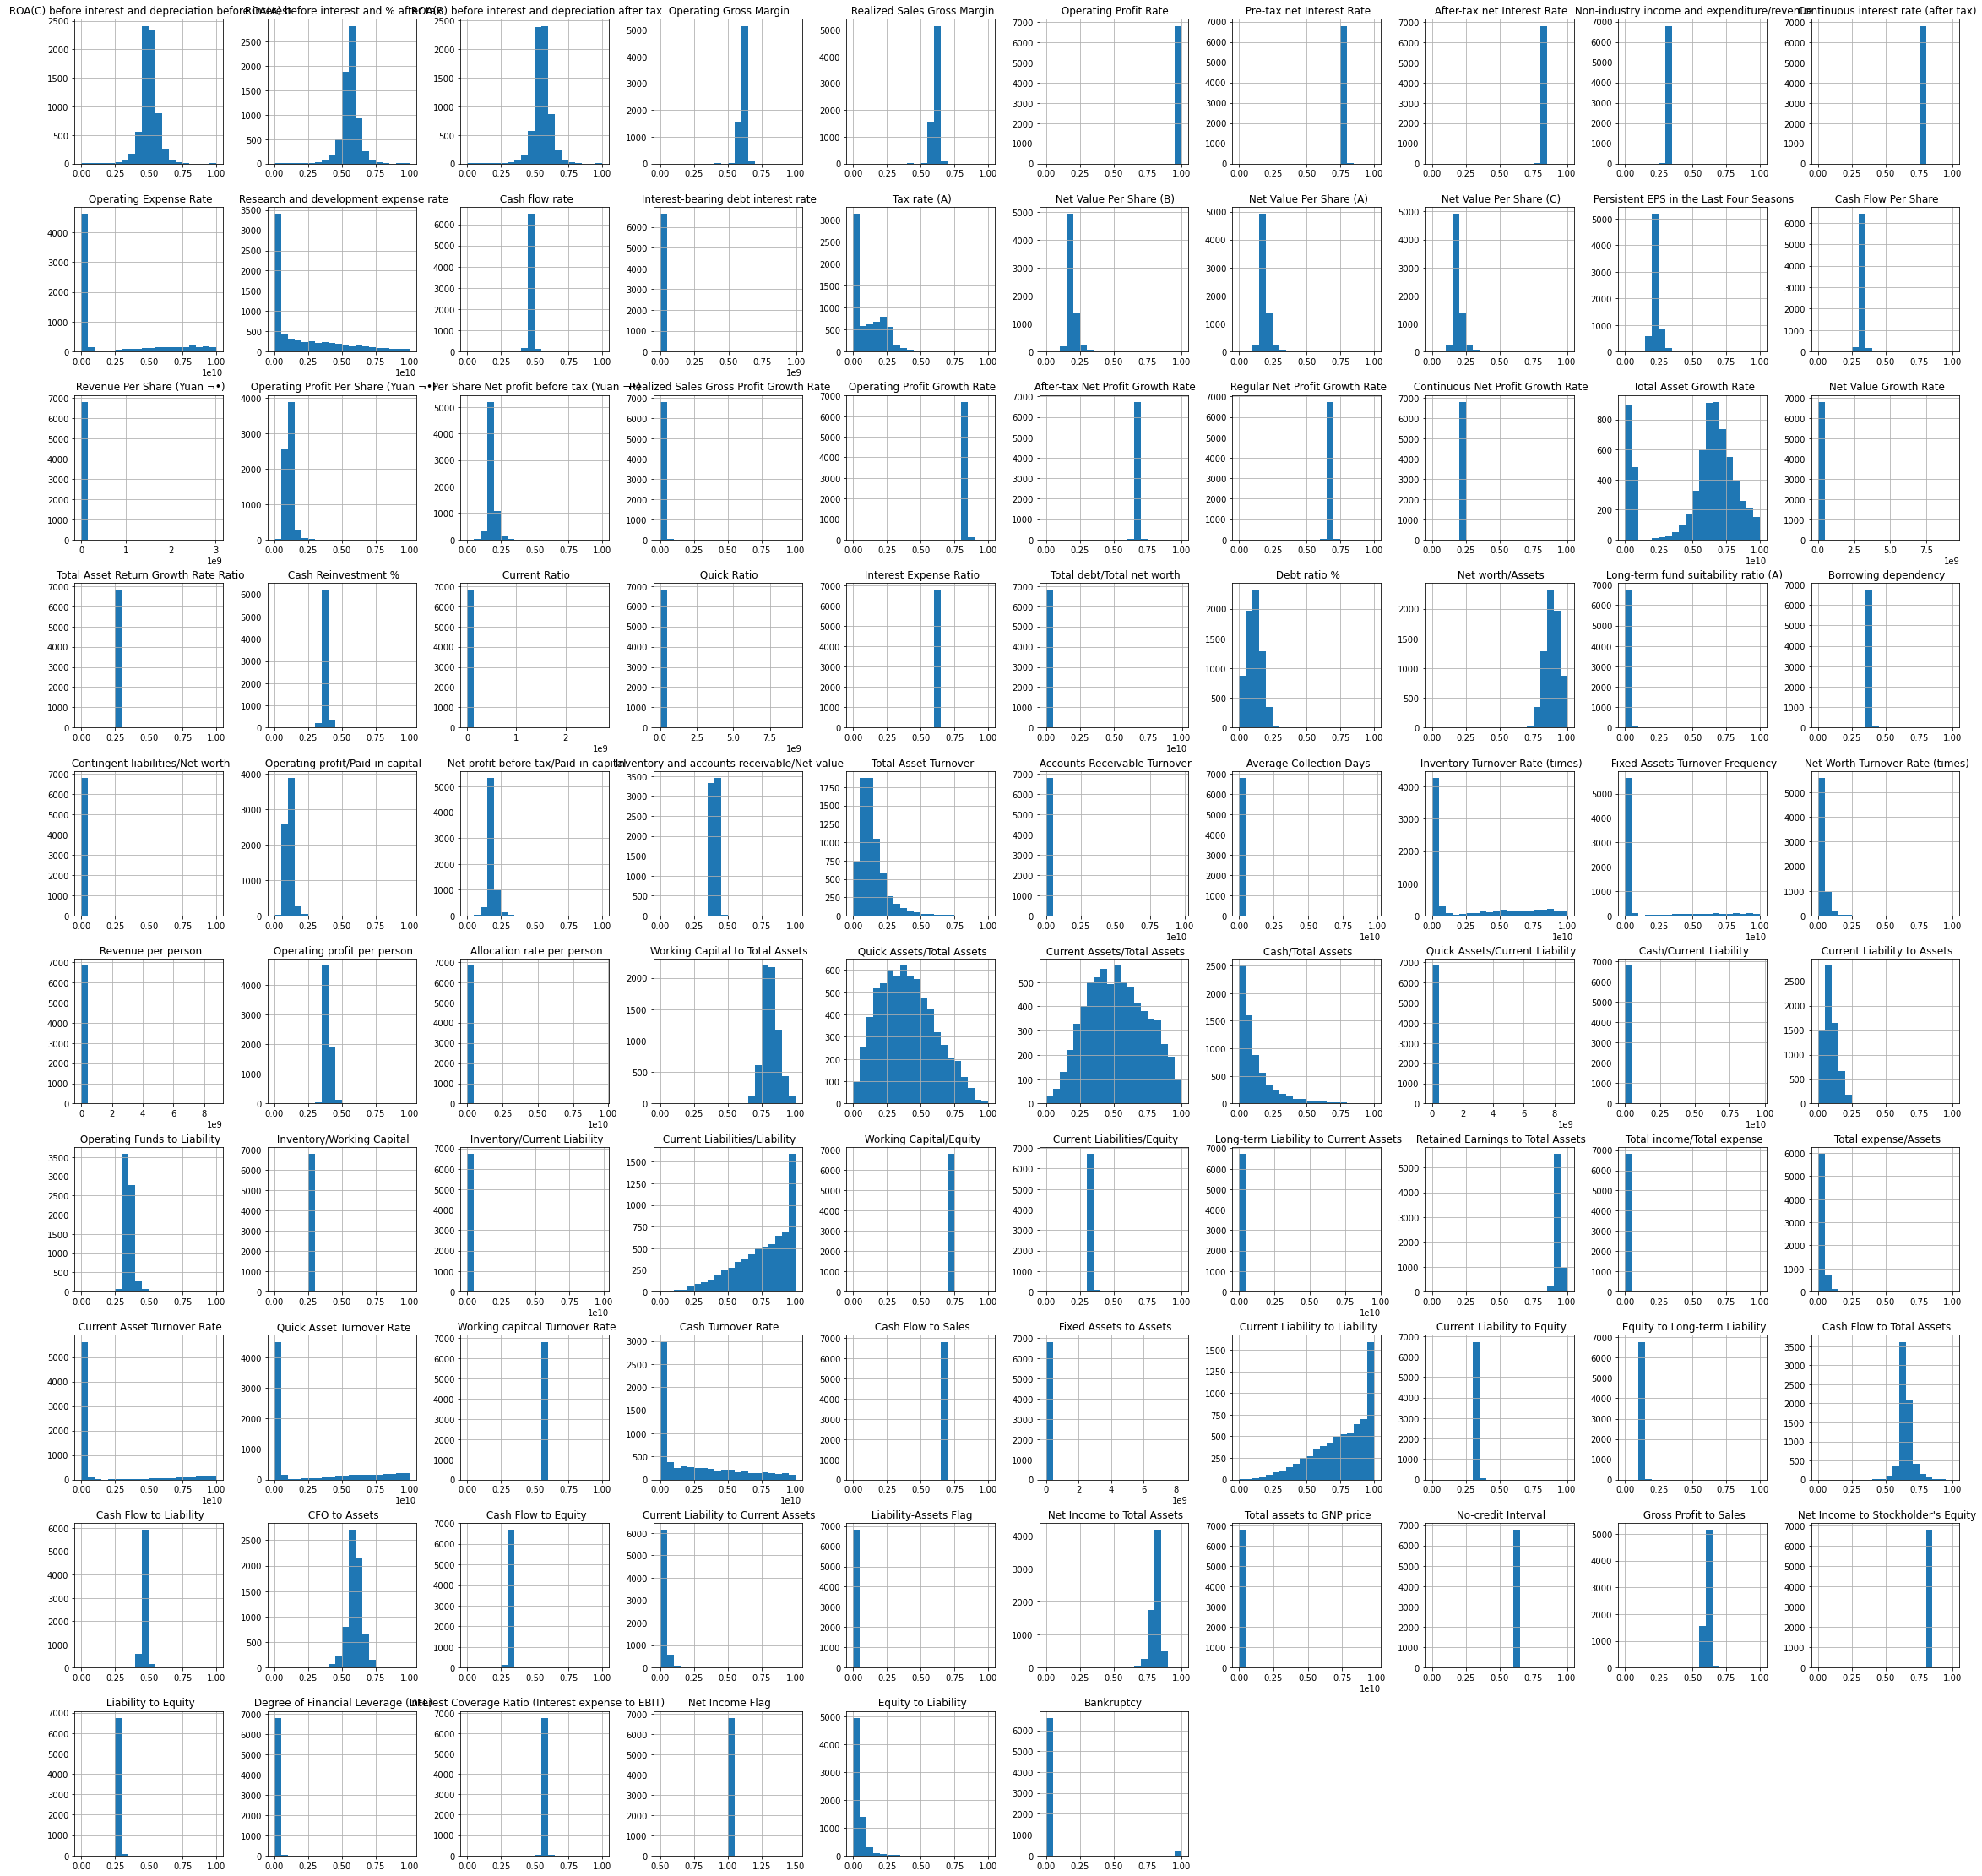

In [27]:
dataset.hist(figsize=(40,40), bins = 20)
plt.show()

We can see from gazing at the histograms above that our data contains a lot of outliers and extremal values. We'll look to deal with those later.

Something else we may need to care about is _multicollinearity_. This is when multiple columns are all highly correlated - this shouldn't affect our model's performance as random forests and decision trees pick leaves that explain the must information (_impurity_), however it will affect our ability to interpret the most important features of the model. Once our decision trees have chosen one of the collinear variables, then the rest of our variables are seen as less important as they explain the same data as the chosen variable.

This leaves us with a plan of action:
1. Impute missing values with median
1. Impute outliers with the median 
1. Handle collinear features.

## Data Cleaning

We defined our plan of action in the previous section, so we can get started with step 1:

### Missing Data

As our dataset is already quite small, and since we have no nulls in our target column we choose to impute our missing values with the median rather than removing them completely.

In [28]:
datasetNoMissing = dataset.fillna(dataset.median())

This should've solved our missing value issue, we can rerun the code from earlier to check:

In [29]:
## we iterate over the columns and find those with null values, we can see from above that they're very sparse
nullCols = [col for col in datasetNoMissing if datasetNoMissing[col].isna().sum() > 0]

nullCols 

[]

### Duplicates

In [30]:
datasetNoMissing.drop_duplicates().reset_index(drop = True)

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Company type,Bankruptcy
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,Partnership,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,Partnership,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,Partnership,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,Partnership,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,Limited Company,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890,Limited Company,0
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284,Partnership,0
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649,Limited Company,0
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009,Limited Company,0


### Outlier handling

In [31]:
def outlier_impute(dataset):
    """
    dataset: pandas DataFrame
    
    This function removes outliers for float columns and imputes the column median in their place.
    """
    for col in dataset:
        if dataset[col].dtype == 'float64':
            perc25 = np.percentile(dataset[col], 25)
            perc75 = np.percentile(dataset[col], 75)
            IQR = perc75 - perc25
            
            outlierRange = IQR * 1.5
            lowerBound = perc25 - outlierRange
            upperBound = perc75 + outlierRange
            dataset[col] = dataset[col].mask(~dataset[col].between(lowerBound, upperBound), dataset[col].median())
            
            print(col+"'s outliers fixed.")
        else:
            print("Non float column")

In [33]:
datasetNoOutliers = datasetNoMissing.copy()

outlier_impute(datasetNoOutliers)

 ROA(C) before interest and depreciation before interest's outliers fixed.
 ROA(A) before interest and % after tax's outliers fixed.
 ROA(B) before interest and depreciation after tax's outliers fixed.
 Operating Gross Margin's outliers fixed.
 Realized Sales Gross Margin's outliers fixed.
 Operating Profit Rate's outliers fixed.
 Pre-tax net Interest Rate's outliers fixed.
 After-tax net Interest Rate's outliers fixed.
 Non-industry income and expenditure/revenue's outliers fixed.
 Continuous interest rate (after tax)'s outliers fixed.
 Operating Expense Rate's outliers fixed.
 Research and development expense rate's outliers fixed.
 Cash flow rate's outliers fixed.
 Interest-bearing debt interest rate's outliers fixed.
 Tax rate (A)'s outliers fixed.
 Net Value Per Share (B)'s outliers fixed.
 Net Value Per Share (A)'s outliers fixed.
 Net Value Per Share (C)'s outliers fixed.
 Persistent EPS in the Last Four Seasons's outliers fixed.
 Cash Flow Per Share's outliers fixed.
 Revenue P

## Model building

#### Feature selection

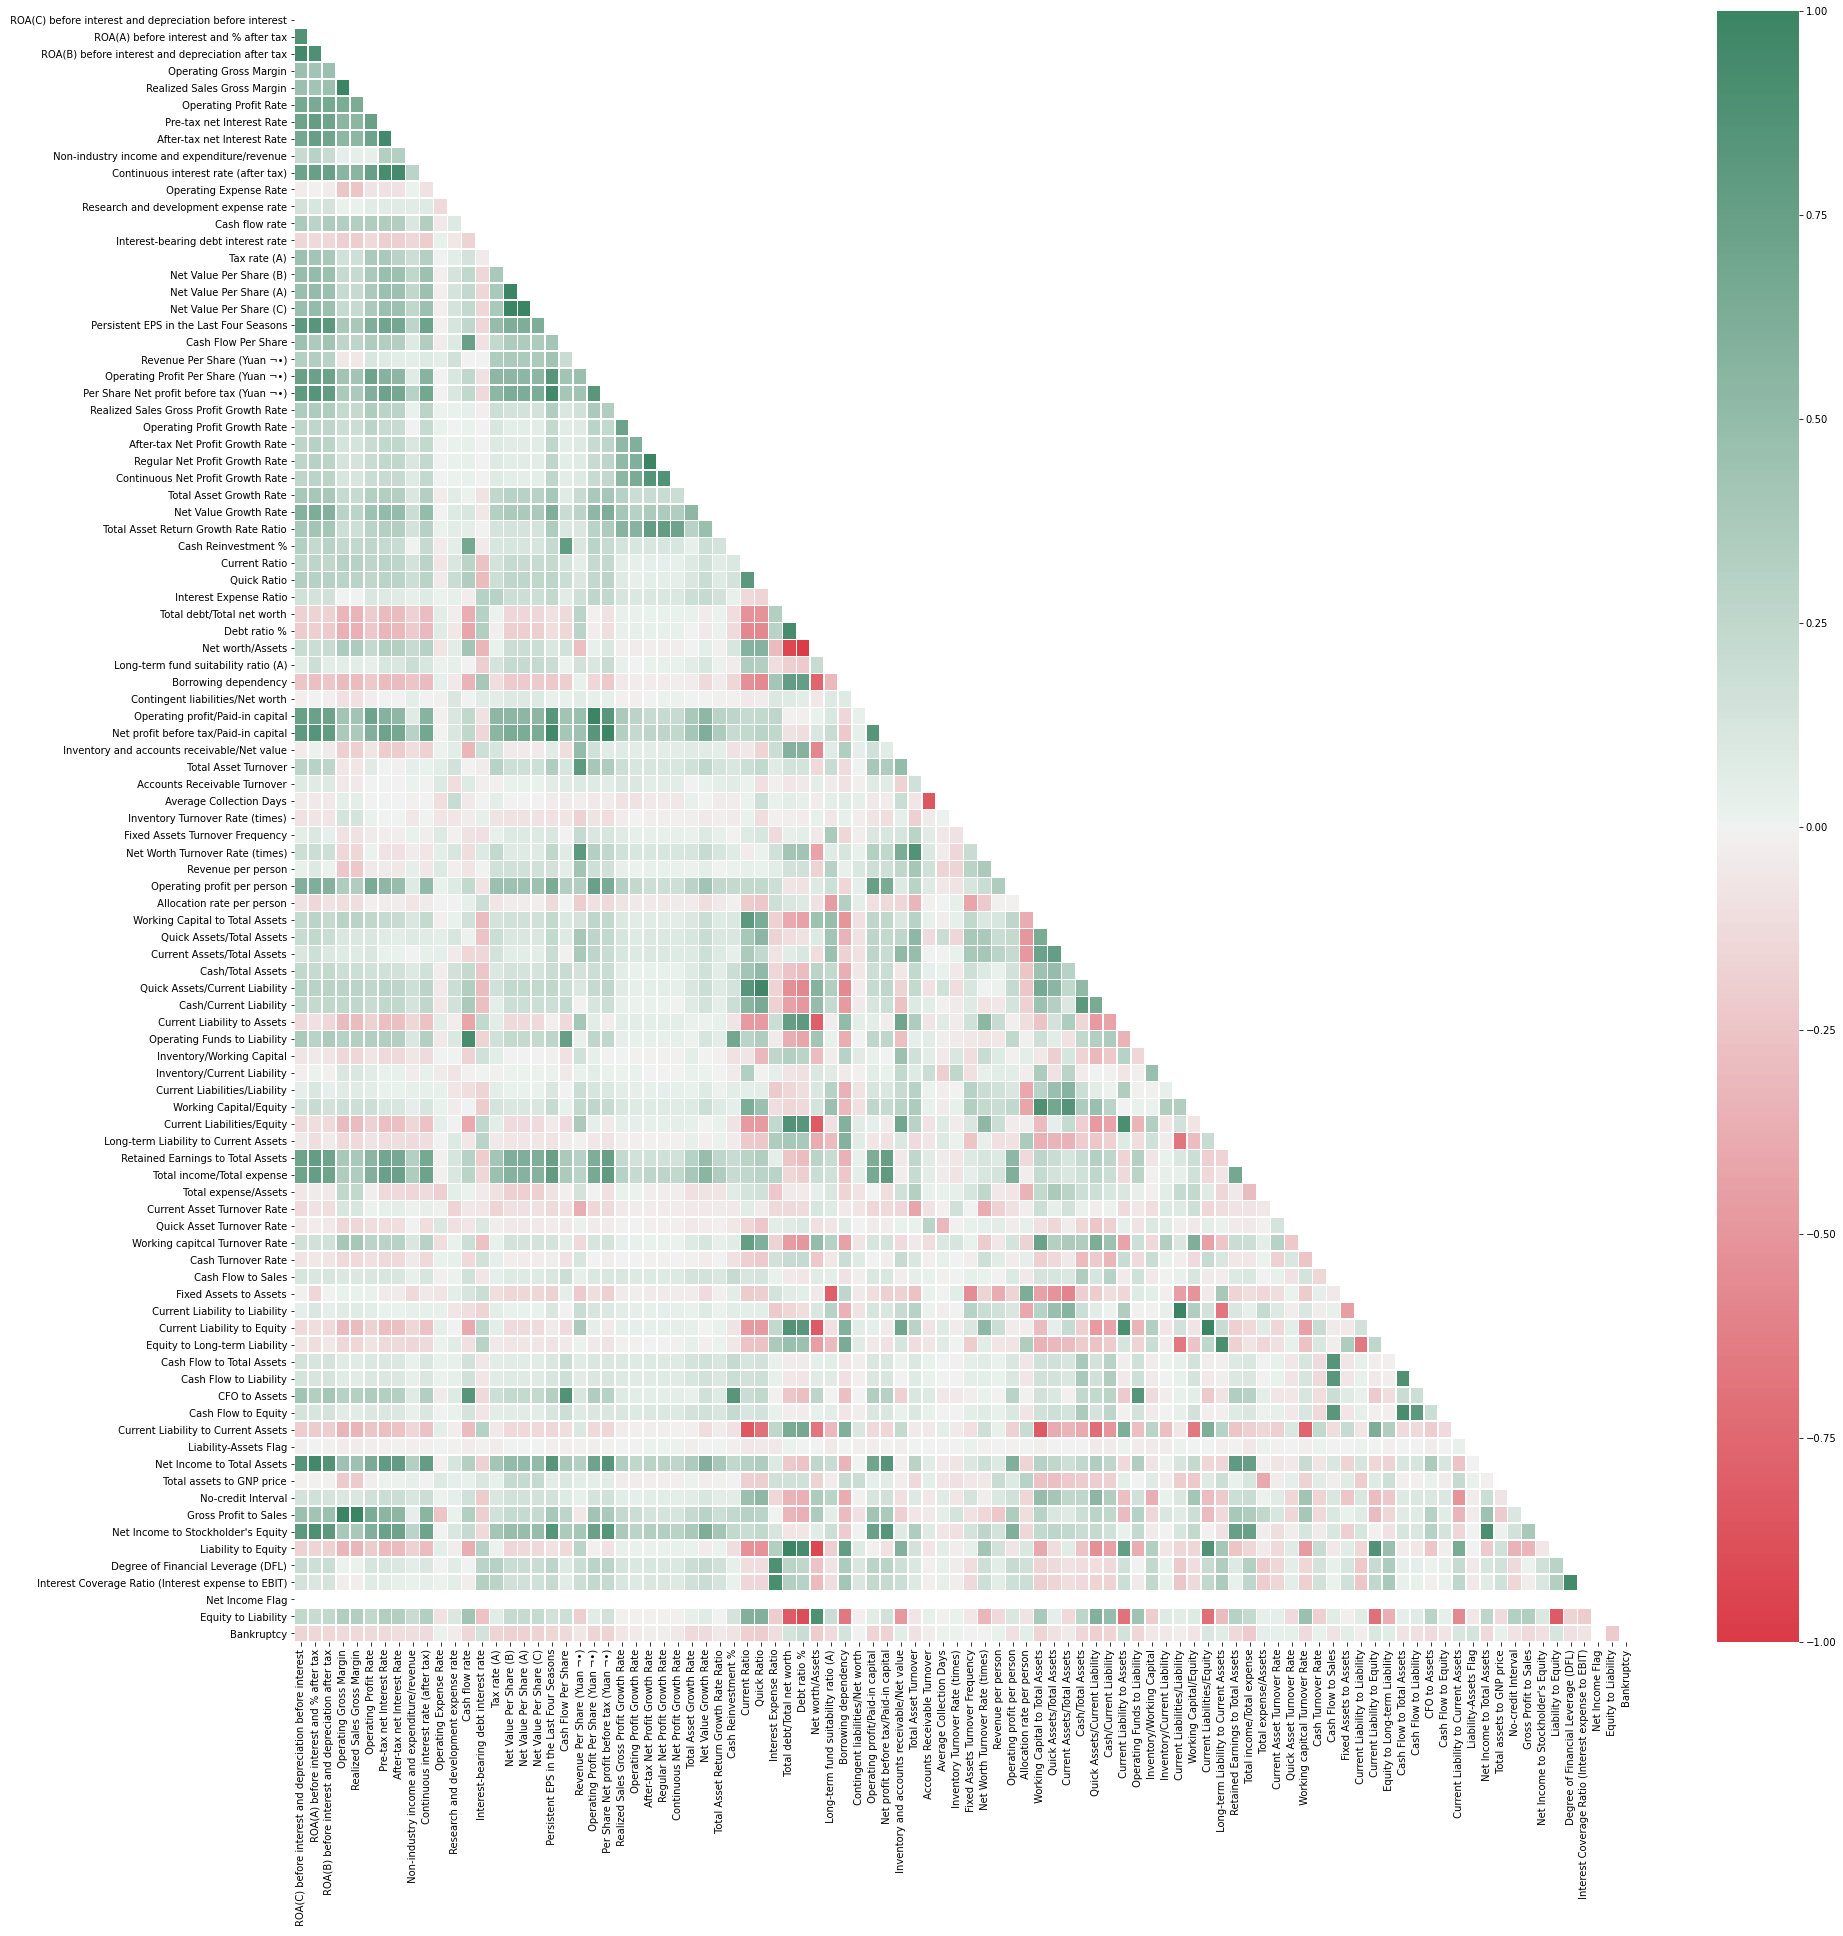

In [34]:
## finds the correlations
correlations = datasetNoOutliers.corr('spearman')

## we now define a mask to hide our duplicated correlations
mask = np.triu(np.ones_like(correlations, dtype=bool))
## then we define our colour palette to make the correlations more noticeable
cmap = sns.diverging_palette(10, 150, as_cmap=True)

## we now set out plot to be large enough to be interpretable
plt.subplots(figsize=(30, 30))
sns.heatmap(data = correlations, mask = mask, center = 0, cmap = cmap, linewidths= 0.5)
plt.show()

This isn't meant to show much, with decision trees feature importance is implicit, i.e. the algorithm works by choosing the most important features to explain variance, so we can use this as a reference.

### Test-train splitting

We use solely test and train rather than test, dev, and train, and we'll be using k-fold validation. We start by splitting our dataset into X and y, then into train and test:

In [35]:
X = datasetNoOutliers.drop(labels = ['Bankruptcy'], axis = 1)
y = datasetNoOutliers[['Bankruptcy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 5)

In [38]:
print("Our train and test sets both have {:} rows, and {:} and {:} columns respectively.".format(X_train.shape[1], X_train.shape[0], X_test.shape[0]))

Our train and test sets both have 96 rows, and 5455 and 1364 columns respectively.


### Class imbalance

We know our dataset is very imbalanced, in order to combat this we use SMOTENC synthetic sampling on our data. As we're using k-fold cross validation, we can't oversample our data right now

#### SMOTENC synthetic sampling

In [39]:
smoteNC = SMOTENC(categorical_features = [95], random_state = 4432)

In [40]:
X_res, y_res = smoteNC.fit_resample(X_train, y_train)

### Categoric Encoding

sklearn dts and rfs don't handle categories natively so we ohencode our data

### Model selection

#### Decision tree

#### Random forest

#### Gradient boosted decision trees

### Performance evaluation